# Life Expectancy using Linear Regression
## Milestone 5: Regression Analysis

In [1]:
# statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.stats.outliers_influence as sts
from patsy import dmatrices

import scipy.stats as stats
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## 5.1 Build the Model

### 1. Previous Exploration

In [2]:
# Read the resulting file from milestone 3 *state_data_clean.csv* into a dataframe
df = pd.read_csv("./csv/state_data_clean.csv", index_col="State")
# Make the columns "Region" and "Division” categorical. 
df["Region"] = pd.Categorical(df["Region"], ordered=False)
df["Division"] = pd.Categorical(df["Division"], ordered=False)
# Define a new column “Income” that is the result of dividing “Income2017” by 1000. 
df['Income'] = df['Income2017']/1000
df['Pop'] = df['Pop']/1000
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Alaska to Wyoming
Data columns (total 22 columns):
HSGradPer        48 non-null float64
BADegPer         48 non-null float64
AdvDegPer        48 non-null float64
LifeExp2018      48 non-null float64
MaleLifeExp      48 non-null float64
FemLifeExp       48 non-null float64
Pop              48 non-null float64
MurderNMTot      48 non-null int64
MurderTot        48 non-null float64
GunMurderTot     48 non-null float64
GunOwnPer        48 non-null float64
MurderNMRate     48 non-null float64
MurderRate       48 non-null float64
GunMurderRate    48 non-null float64
TotalKmQ         48 non-null int64
LandKmQ          48 non-null int64
WaterKmQ         48 non-null int64
Income2017       48 non-null int64
Abb              48 non-null object
Region           48 non-null category
Division         48 non-null category
Income           48 non-null float64
dtypes: category(2), float64(14), int64(5), object(1)
memory usage: 8.5+ KB


In [3]:
# check that everything was correctly loaded
df.head()

,HSGradPer,BADegPer,AdvDegPer,LifeExp2018,MaleLifeExp,FemLifeExp,Pop,MurderNMTot,MurderTot,GunMurderTot,...,MurderRate,GunMurderRate,TotalKmQ,LandKmQ,WaterKmQ,Income2017,Abb,Region,Division,Income
State,,,,,,,,,,,,,,,,,,,,,
Alaska,92.4,29.0,10.4,78.8,76.7,81.2,0.738,59,57.0,39.0,...,7.7,5.3,1723337,1477953,245384,73181,AK,West,Pacific,73.181
Arizona,82.1,28.4,10.7,79.9,77.5,82.3,6.818,306,278.0,171.0,...,4.1,2.5,295234,294207,1026,56581,AZ,West,Mountain,56.581
Arkansas,85.6,22.0,7.9,75.9,73.1,78.6,2.978,181,164.0,110.0,...,5.5,3.7,137732,134771,2961,45869,AR,South,West South Central,45.869
California,82.5,32.6,12.2,81.6,79.4,83.8,38.994,1861,1861.0,1275.0,...,4.8,3.3,423967,403466,20501,71805,CA,West,Pacific,71.805
Colorado,91.1,39.4,14.6,80.5,78.5,82.5,5.449,176,176.0,115.0,...,3.2,2.1,269601,268431,1170,69117,CO,West,Mountain,69.117


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Alaska to Wyoming
Data columns (total 22 columns):
HSGradPer        48 non-null float64
BADegPer         48 non-null float64
AdvDegPer        48 non-null float64
LifeExp2018      48 non-null float64
MaleLifeExp      48 non-null float64
FemLifeExp       48 non-null float64
Pop              48 non-null float64
MurderNMTot      48 non-null int64
MurderTot        48 non-null float64
GunMurderTot     48 non-null float64
GunOwnPer        48 non-null float64
MurderNMRate     48 non-null float64
MurderRate       48 non-null float64
GunMurderRate    48 non-null float64
TotalKmQ         48 non-null int64
LandKmQ          48 non-null int64
WaterKmQ         48 non-null int64
Income2017       48 non-null int64
Abb              48 non-null object
Region           48 non-null category
Division         48 non-null category
Income           48 non-null float64
dtypes: category(2), float64(14), int64(5), object(1)
memory usage: 8.5+ KB


In [5]:
df.describe()

,HSGradPer,BADegPer,AdvDegPer,LifeExp2018,MaleLifeExp,FemLifeExp,Pop,MurderNMTot,MurderTot,GunMurderTot,GunOwnPer,MurderNMRate,MurderRate,GunMurderRate,TotalKmQ,LandKmQ,WaterKmQ,Income2017,Income
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,4.800000e+01,4.800000e+01,48.000000,48.000000,48.000000
mean,88.593750,30.264583,11.327083,78.739583,76.443750,81.043750,6.148938,294.625000,276.020833,197.145833,32.775000,4.503333,4.158333,2.897917,1.984846e+05,1.849454e+05,13539.312500,60193.458333,60.193458
std,3.527726,5.089894,2.737582,1.762341,1.915214,1.627412,7.070645,347.436363,338.229526,241.554099,13.621986,2.195513,1.998492,1.695613,2.571958e+05,2.267155e+05,37587.988226,9850.680620,9.850681
min,76.700000,19.900000,7.800000,74.800000,71.900000,77.400000,0.586000,10.000000,10.000000,4.000000,5.200000,1.100000,1.100000,0.300000,4.001000e+03,2.678000e+03,497.000000,43469.000000,43.469000
25%,86.250000,26.975000,9.525000,77.950000,75.375000,80.150000,1.794000,61.250000,57.000000,34.000000,25.300000,2.775000,2.675000,1.575000,9.365275e+04,8.956250e+04,1746.250000,53530.000000,53.530000
50%,89.550000,29.900000,10.750000,79.100000,76.800000,81.300000,4.225000,179.500000,170.000000,114.000000,32.050000,4.350000,4.100000,2.800000,1.478705e+05,1.420305e+05,3706.500000,58882.500000,58.882500
75%,91.450000,33.100000,12.750000,79.900000,77.725000,81.950000,6.903500,424.750000,396.000000,300.750000,42.500000,5.850000,5.350000,3.825000,2.212022e+05,2.120200e+05,10621.250000,68365.500000,68.365500
max,93.000000,42.100000,18.700000,82.300000,79.400000,85.300000,38.994000,1861.000000,1861.000000,1275.000000,61.700000,10.300000,10.200000,8.100000,1.723337e+06,1.477953e+06,245384.000000,80776.000000,80.776000


Let's compute the correlations between the predictors

In [6]:
# Compute the correlation matrix between the variables and plot a heatmap
# We've defined afunction for this purpose

def corr_heatmap(df, columns_list):
    df = df.loc[:,columns_list]
    corr_matrix = df.corr()
    print(corr_matrix)
    w = len(columns_list)*2
    h = len(columns_list)
    fig, ax0 = plt.subplots(figsize=(w, h))
    sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", ax=ax0)
    # margins bug
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t-0.5)
    plt.show()


               LifeExp2018    Income  MurderNMRate  GunMurderRate  HSGradPer  \
LifeExp2018       1.000000  0.799920     -0.603276      -0.538607   0.303530   
Income            0.799920  1.000000     -0.350932      -0.308288   0.366523   
MurderNMRate     -0.603276 -0.350932      1.000000       0.940958  -0.378155   
GunMurderRate    -0.538607 -0.308288      0.940958       1.000000  -0.281928   
HSGradPer         0.303530  0.366523     -0.378155      -0.281928   1.000000   
BADegPer          0.769071  0.840382     -0.415559      -0.339823   0.339913   
AdvDegPer         0.559543  0.725105     -0.219847      -0.178153   0.151483   
TotalKmQ          0.055883  0.083940      0.215630       0.183447  -0.003992   
Pop               0.210570  0.166017      0.120038       0.160551  -0.401781   

               BADegPer  AdvDegPer  TotalKmQ       Pop  
LifeExp2018    0.769071   0.559543  0.055883  0.210570  
Income         0.840382   0.725105  0.083940  0.166017  
MurderNMRate  -0.415559  -0.

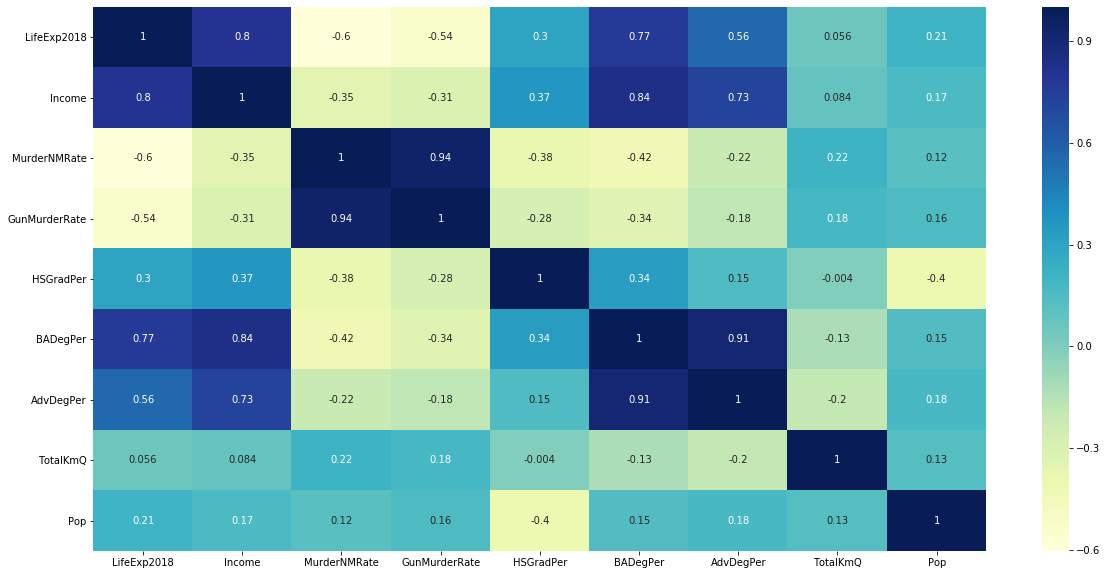

In [7]:
corr_heatmap(df,['LifeExp2018', 'Income', 'MurderNMRate', 'GunMurderRate', 'HSGradPer', 'BADegPer', 'AdvDegPer', 'TotalKmQ', 'Region', 'Pop'])

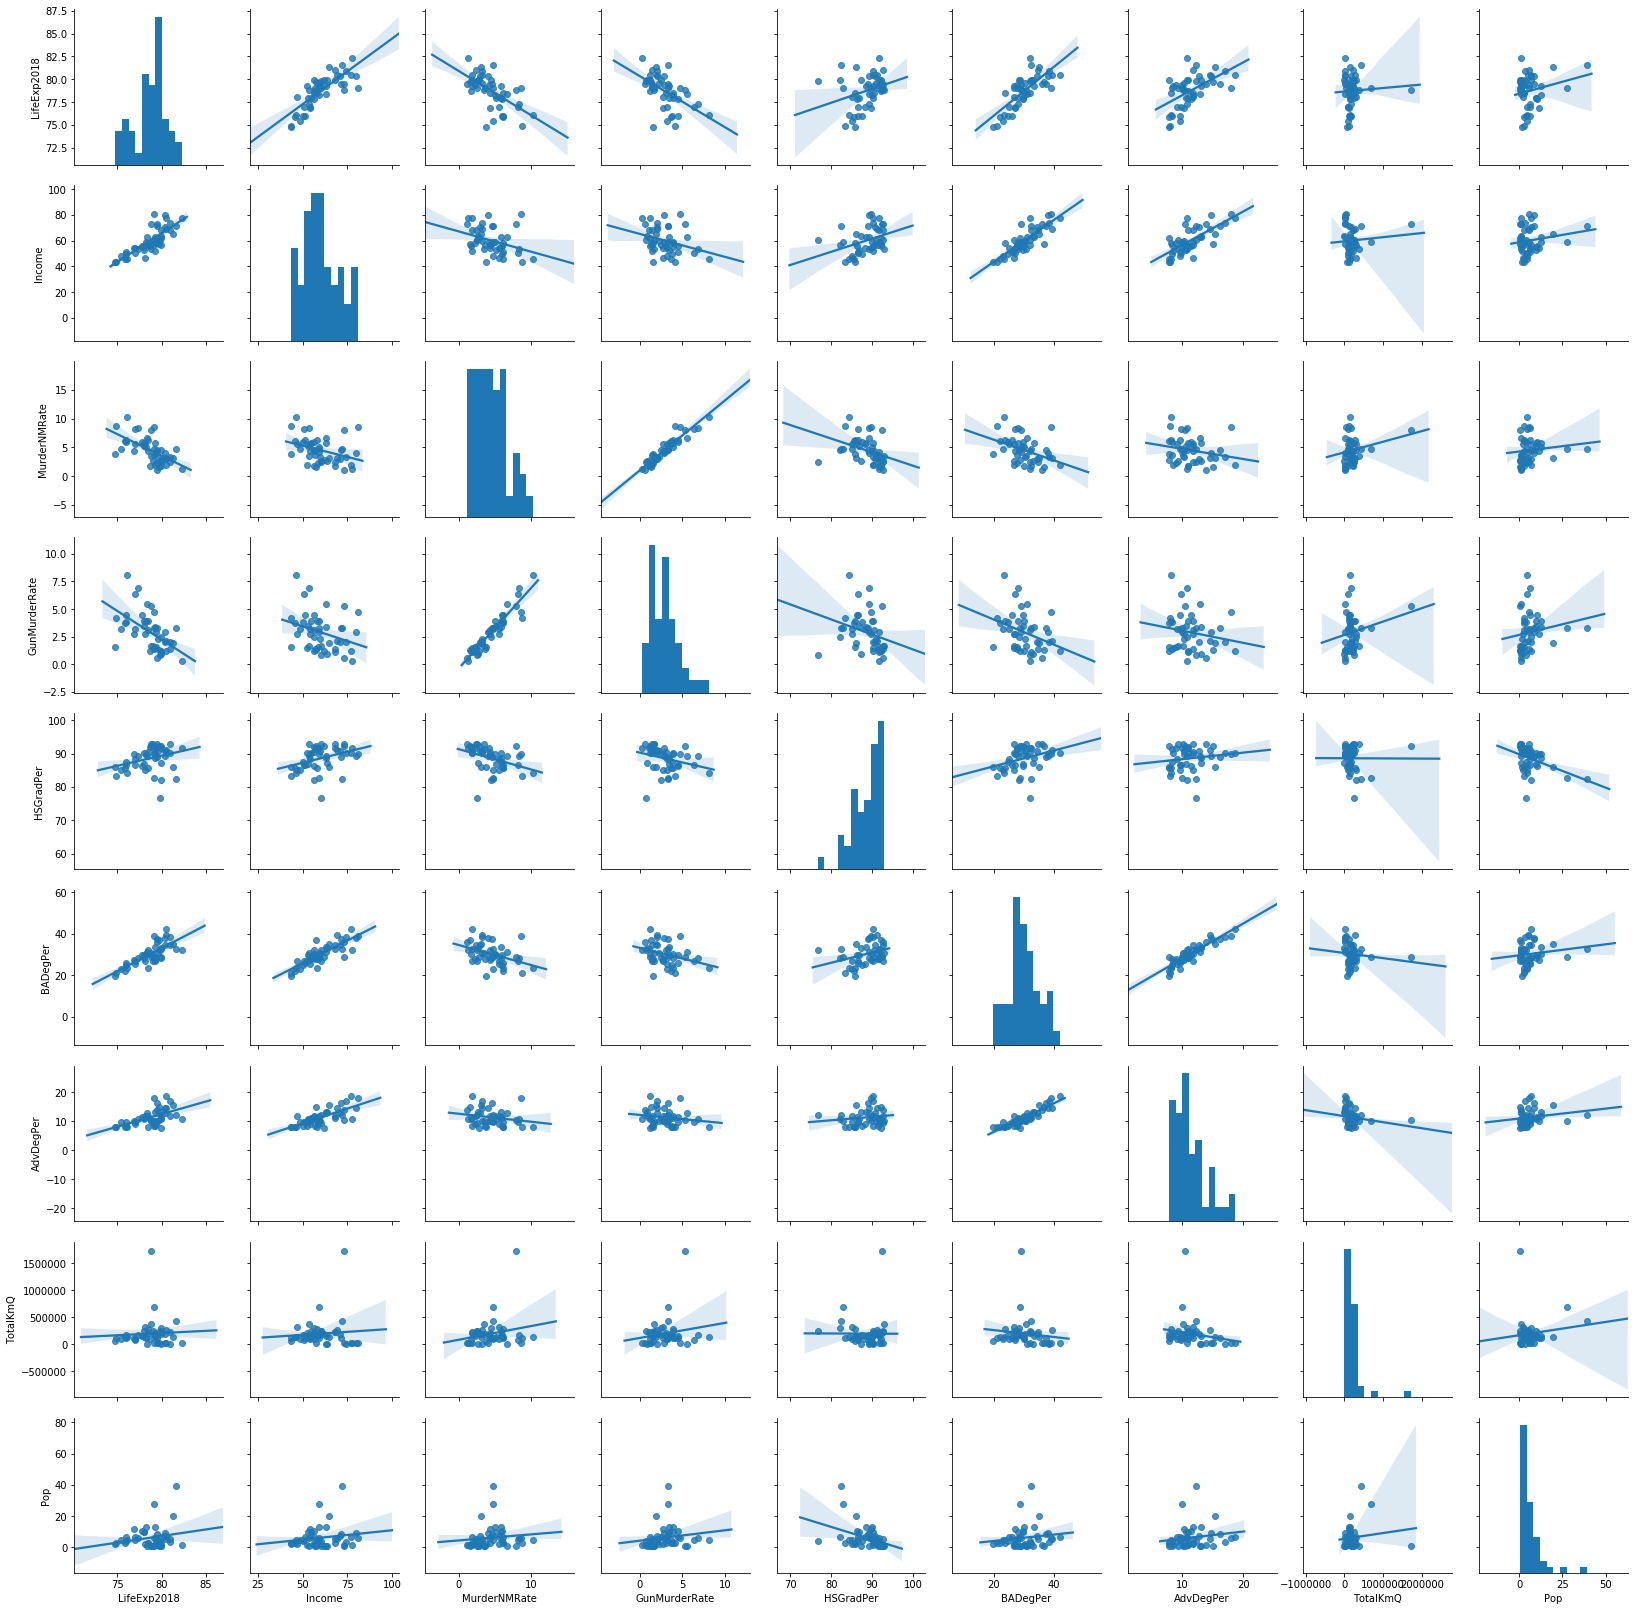

In [8]:
# Scatterplot matrix
g = sns.pairplot(df[['LifeExp2018', 'Income', 'MurderNMRate', 'GunMurderRate', 'HSGradPer', 'BADegPer', 'AdvDegPer', 'TotalKmQ', 'Region', 'Pop']], kind = "reg")
plt.savefig("./img/scatterplot_matrix.png")    

Which predictor variables are highle correlated with each other:   
Income is higly correlated with BADegPer, and AdvDegPer   
GunMurderRate is highly correlated with GunMurderRate   
BADegPer and AdvDegPer are highly correlated   

### 2. Select the modelling technique and build the model

To select the variables of our model we are going to use the approach of stepwise forward regression. We then going to check the models found by the algorithm. 

The method of forward stepwise regression adds one variable at a time.    
To compare between models, we’ll use the *adjusted R2* statistic. The R2 statistic provides a measure of fit in the form of a proportion (0 <= R2 <= 1). This fact makes it easier to compare between models.    
The problem with the R2 statistic is that it always increases when we add more predictors. Since the approach we are using to select the variables adds one predictor at a time, the R2 will always increase. To avoid this problem we will use the adjusted R2 statistic that penalizes the inclusion of unnecessary variables.

In [9]:
def forward_selection(df, response):
    """Linear model by all subsets selection.

    Parameters:
    -----------
    df : pandas DataFrame with all variables
    response : name of the response variable

    Returns:
    --------
    list of the selected models
    list pf corresponding adjusted R^2
    list of strings columns corresponding to the predictors that make the "optimal" model

    """  
    
    selected_models, selected_scores, selected_preds = [], [], []
    max_score, best_score = 0.0, 0.0
    remaining_preds = set(df.columns)
    remaining_preds.remove(response)
    while remaining_preds and max_score == best_score:
        list_scores_models = []
        for new_pred in remaining_preds:
            predictors_fla = ' + '.join(selected_preds + [new_pred])
            current_formula = "{} ~ {} ".format(response,predictors_fla)
            # do the regression and compute R^2 
            y, current_X = dmatrices(current_formula, data=df, return_type='dataframe')
            model = sm.OLS(y, current_X)    # Describe model
            results = model.fit()       # Fit model
            adjRsqr = results.rsquared_adj # compute adj R^2
            list_scores_models.append((adjRsqr, new_pred, model))
        # which of the examined candidates gave the biggest adjR^2
        list_scores_models.sort()
        best_score, best_pred, best_model = list_scores_models.pop()
        print("Best model adds {} - adjR2: {:.4f}".format(best_pred,best_score))
        if max_score < best_score:
            remaining_preds.remove(best_pred)
            selected_models.append(best_model)
            selected_scores.append(best_score)
            selected_preds.append(best_pred)
            max_score = best_score
    return (selected_models,selected_scores, selected_preds)


### 3. Build the model

We apply forward stepwise regression to the data.

In [10]:
df_reg = df.loc[:,['LifeExp2018', 'Income', 'MurderNMRate', 'GunMurderRate', 'HSGradPer', 'BADegPer', 'AdvDegPer', 'TotalKmQ', 'Region', 'Pop']].copy()
models, scores, preds = forward_selection(df_reg,'LifeExp2018')

Best model adds Income - adjR2: 0.6320
Best model adds Region - adjR2: 0.7633
Best model adds MurderNMRate - adjR2: 0.7983
Best model adds Pop - adjR2: 0.8225
Best model adds BADegPer - adjR2: 0.8435
Best model adds AdvDegPer - adjR2: 0.8546
Best model adds HSGradPer - adjR2: 0.8592
Best model adds TotalKmQ - adjR2: 0.8563


Adjusted R2s
 Income          0.632043
Region          0.763267
MurderNMRate    0.798288
Pop             0.822542
BADegPer        0.843533
AdvDegPer       0.854573
HSGradPer       0.859195
dtype: float64


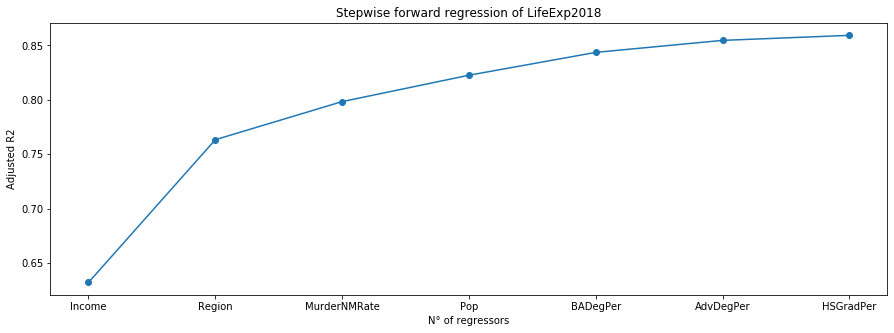

In [11]:
# check the adjusted R2 statistic 
results = [m.fit() for m in models]
adjR2s = pd.Series(scores, index = preds)
print("Adjusted R2s\n",adjR2s)
fig, ax0 = plt.subplots( figsize=(15, 5))
ax0.plot(adjR2s, marker = "o")
ax0.set(title="Stepwise forward regression of LifeExp2018", xlabel = "N° of regressors", ylabel="Adjusted R2")
plt.savefig("./img/adj_r2.png")    
plt.show()

### 4. Multicollinearity

In [12]:
# function to compute variance inflation factor
def compute_vif(formula,df):
    y, X = dmatrices(formula, df, return_type='dataframe')
    vif = pd.DataFrame()
    vif["VIF Factor"] = [sts.variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif["Sqrt"] = np.sqrt(vif["VIF Factor"])
    vif["features"] = X.columns
    return vif

In [13]:
# Explore multicolinearity
y, X1 = dmatrices('LifeExp2018 ~ BADegPer', data=df, return_type='dataframe')
model1 = sm.OLS(y, X1)    # Describe model
fit1 = model1.fit()       # Fit model
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            LifeExp2018   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     66.60
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           1.72e-10
Time:                        14:55:29   Log-Likelihood:                -73.318
No. Observations:                  48   AIC:                             150.6
Df Residuals:                      46   BIC:                             154.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.6806      1.001     70.602      0.000      68.665      72.696
BADegPer       0.2663      0.033      8.161      0.000       0.201       0.332
==============================================================================
Omnibus:                        2.456   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                2.307
Skew:                           0.513   Prob(JB):                        0.316
Kurtosis:                       2.680   Cond. No.                         187.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
y, X2 = dmatrices('LifeExp2018 ~ AdvDegPer', data=df, return_type='dataframe')
model2 = sm.OLS(y, X2)    # Describe model
fit2 = model2.fit()       # Fit model
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            LifeExp2018   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     20.97
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           3.56e-05
Time:                        14:55:29   Log-Likelihood:                -85.789
No. Observations:                  48   AIC:                             175.6
Df Residuals:                      46   BIC:                             179.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     74.6595      0.916     81.488      0.000      72.815      76.504
AdvDegPer      0.3602      0.079      4.579      0.000       0.202       0.519
==============================================================================
Omnibus:                        0.214   Durbin-Watson:                   2.335
Prob(Omnibus):                  0.899   Jarque-Bera (JB):                0.383
Skew:                           0.124   Prob(JB):                        0.826
Kurtosis:                       2.639   Cond. No.                         50.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
y, X3 = dmatrices('LifeExp2018 ~ BADegPer + AdvDegPer', data=df, return_type='dataframe')
model3 = sm.OLS(y, X3)    # Describe model
fit3 = model3.fit()       # Fit model
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            LifeExp2018   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     55.20
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           7.76e-13
Time:                        14:55:29   Log-Likelihood:                -65.059
No. Observations:                  48   AIC:                             136.1
Df Residuals:                      45   BIC:                             141.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.7809      0.960     71.654      0.000      66.848      70.714
BADegPer       0.5314      0.068      7.858      0.000       0.395       0.668
AdvDegPer     -0.5406      0.126     -4.299      0.000      -0.794      -0.287
==============================================================================
Omnibus:                        5.203   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                4.756
Skew:                           0.771   Prob(JB):                       0.0927
Kurtosis:                       2.976   Cond. No.                         226.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
vif_edu = compute_vif('LifeExp2018 ~ BADegPer + AdvDegPer',df)
vif_edu

,VIF Factor,Sqrt,features
0,47.082734,6.861686,Intercept
1,5.927523,2.434651,BADegPer
2,5.927523,2.434651,AdvDegPer


### Results of the exploration of multicollinearity   

The variables *BADegBer* and *AdvDegPer* are highly correlated, with a correlation coefficient of 0.91.   

The following table shows the resulting coefficients of the regression considering only one variable or both of them.

Regression on |   BADegPer Coef |  AdvDegPer Coef
---------- | ------------|----------
BADegPer   |    0.2663   |  ---
AdvDegPer  |    ---      |  0.3602
BADegPer and AdvDegPer      |    0.5314   | -0.5406

We can see that the coefficients differ when the other variable is included. The coefficient from AdvDegPer even changes sign!

Variance Inflation Factor for the regression : 'LifeExp2018 ~ BADegPer + AdvDegPer'   

Regresor  |   VIF  |  sqrt(VIF)
---------- | ------------|----------
BADegPer   |    5.927523   |  2.434651
AdvDegPer  |    5.927523     |  2.434651

Since the square root of the VIF statistic is greater than 2, there is a multicollinearity problem

### Analysis of the models returned 
##### Model with one predictor
##### LifeExp2018 ~ Income

In [17]:
results[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            LifeExp2018   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     81.73
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           9.09e-12
Time:                        14:55:30   Log-Likelihood:                -70.292
No. Observations:                  48   AIC:                             144.6
Df Residuals:                      46   BIC:                             148.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.1253      0.965     72.649      0.000      68.182      72.068
Income         0.1431      0.016      9.041      0.000       0.111       0.175
==============================================================================
Omnibus:                        2.039   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                1.613
Skew:                          -0.278   Prob(JB):                        0.446
Kurtosis:                       2.295   Cond. No.                         382.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Model with 2 predictors
##### LifeExp2018 ~ Income + Region

In [18]:
results[1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            LifeExp2018   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     38.88
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           9.28e-14
Time:                        14:55:30   Log-Likelihood:                -58.088
No. Observations:                  48   AIC:                             126.2
Df Residuals:                      43   BIC:                             135.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              72.0771      0.883     81.638      0.000      70.297      73.858
Region[T.Northeast]     0.0951      0.400      0.238      0.813      -0.712       0.902
Region[T.South]        -1.3302      0.342     -3.888      0.000      -2.020      -0.640
Region[T.West]          0.4546      0.350      1.301      0.200      -0.250       1.160
Income                  0.1148      0.015      7.913      0.000       0.086       0.144
==============================================================================
Omnibus:                        0.547   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.761   Jarque-Bera (JB):                0.665
Skew:                          -0.217   Prob(JB):                        0.717
Kurtosis:                       2.619   Cond. No.                         441.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
vif1 = compute_vif('LifeExp2018 ~ Income + Region',df)
vif1

,VIF Factor,Sqrt,features
0,50.887845,7.133572,Intercept
1,1.591248,1.261447,Region[T.Northeast]
2,1.578949,1.256563,Region[T.South]
3,1.575534,1.255203,Region[T.West]
4,1.305225,1.142464,Income


##### Model with 3 predictors
##### LifeExp2018 ~ Income + Region + MurderNMRate

In [20]:
results[2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            LifeExp2018   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     38.20
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           1.41e-14
Time:                        14:55:30   Log-Likelihood:                -53.681
No. Observations:                  48   AIC:                             119.4
Df Residuals:                      42   BIC:                             130.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              73.1461      0.894     81.822      0.000      71.342      74.950
Region[T.Northeast]    -0.2013      0.383     -0.526      0.602      -0.974       0.572
Region[T.South]        -0.9498      0.342     -2.779      0.008      -1.640      -0.260
Region[T.West]          0.3419      0.325      1.052      0.299      -0.314       0.998
Income                  0.1113      0.013      8.276      0.000       0.084       0.138
MurderNMRate           -0.1959      0.067     -2.910      0.006      -0.332      -0.060
==============================================================================
Omnibus:                        0.475   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.789   Jarque-Bera (JB):                0.621
Skew:                          -0.181   Prob(JB):                        0.733
Kurtosis:                       2.577   Cond. No.                         480.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

                Income  MurderNMRate
Income        1.000000     -0.350932
MurderNMRate -0.350932      1.000000


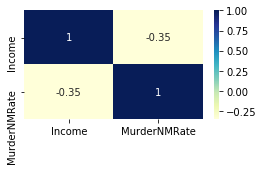

In [21]:
corr_heatmap(df,['Income','MurderNMRate'])

In [22]:
vif2 = compute_vif('LifeExp2018 ~ Income + Region + MurderNMRate',df)
vif2

,VIF Factor,Sqrt,features
0,61.230554,7.824995,Intercept
1,1.712388,1.308583,Region[T.Northeast]
2,1.849515,1.359969,Region[T.South]
3,1.598252,1.264220,Region[T.West]
4,1.315873,1.147115,Income
5,1.638709,1.280121,MurderNMRate


##### Model with 4 predictors
##### LifeExp2018 ~ Income + Region + MurderNMRate + Pop

In [23]:
results[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            LifeExp2018   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     37.31
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           4.32e-15
Time:                        14:55:30   Log-Likelihood:                -50.028
No. Observations:                  48   AIC:                             114.1
Df Residuals:                      41   BIC:                             127.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              73.4473      0.846     86.768      0.000      71.738      75.157
Region[T.Northeast]    -0.1982      0.359     -0.552      0.584      -0.924       0.527
Region[T.South]        -0.9792      0.321     -3.052      0.004      -1.627      -0.331
Region[T.West]          0.3529      0.305      1.157      0.254      -0.263       0.969
Income                  0.1039      0.013      8.037      0.000       0.078       0.130
MurderNMRate           -0.2192      0.064     -3.437      0.001      -0.348      -0.090
Pop                     0.0411      0.016      2.596      0.013       0.009       0.073
==============================================================================
Omnibus:                        2.708   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.258   Jarque-Bera (JB):                2.555
Skew:                          -0.505   Prob(JB):                        0.279
Kurtosis:                       2.493   Cond. No.                         487.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

                Income  MurderNMRate       Pop
Income        1.000000     -0.350932  0.166017
MurderNMRate -0.350932      1.000000  0.120038
Pop           0.166017      0.120038  1.000000


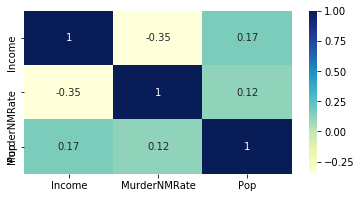

In [24]:
corr_heatmap(df,['Income','MurderNMRate','Pop'])

In [25]:
vif3 = compute_vif('LifeExp2018 ~ Income + Region + MurderNMRate + Pop ',df)
vif3

,VIF Factor,Sqrt,features
0,62.402270,7.899511,Intercept
1,1.712407,1.308590,Region[T.Northeast]
2,1.851830,1.360820,Region[T.South]
3,1.598558,1.264341,Region[T.West]
4,1.382659,1.175865,Income
5,1.671919,1.293027,MurderNMRate
6,1.070487,1.034644,Pop


##### Model with 5 predictors
##### LifeExp2018 ~ Income + Region + MurderNMRate + Pop + BADegPer

In [26]:
results[4].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            LifeExp2018   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     37.20
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           1.45e-15
Time:                        14:55:30   Log-Likelihood:                -46.414
No. Observations:                  48   AIC:                             108.8
Df Residuals:                      40   BIC:                             123.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              72.6351      0.856     84.825      0.000      70.904      74.366
Region[T.Northeast]    -0.4312      0.349     -1.234      0.225      -1.138       0.275
Region[T.South]        -0.9757      0.301     -3.239      0.002      -1.585      -0.367
Region[T.West]          0.4529      0.289      1.567      0.125      -0.131       1.037
Income                  0.0631      0.020      3.142      0.003       0.023       0.104
MurderNMRate           -0.1936      0.061     -3.189      0.003      -0.316      -0.071
Pop                     0.0387      0.015      2.596      0.013       0.009       0.069
BADegPer                0.1052      0.041      2.550      0.015       0.022       0.189
==============================================================================
Omnibus:                        1.332   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.514   Jarque-Bera (JB):                1.207
Skew:                          -0.231   Prob(JB):                        0.547
Kurtosis:                       2.375   Cond. No.                         586.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

                Income  MurderNMRate       Pop  BADegPer
Income        1.000000     -0.350932  0.166017  0.840382
MurderNMRate -0.350932      1.000000  0.120038 -0.415559
Pop           0.166017      0.120038  1.000000  0.147485
BADegPer      0.840382     -0.415559  0.147485  1.000000


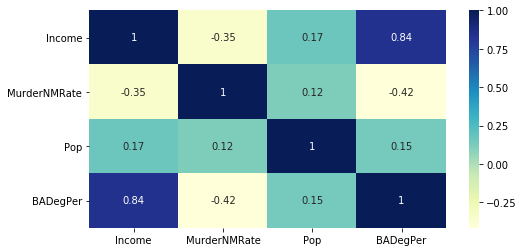

In [27]:
corr_heatmap(df,['Income','MurderNMRate','Pop','BADegPer'])

In [28]:
vif4 = compute_vif('LifeExp2018 ~ Income + Region + MurderNMRate + Pop + BADegPer',df)
vif4

,VIF Factor,Sqrt,features
0,72.424768,8.510274,Intercept
1,1.838032,1.355741,Region[T.Northeast]
2,1.851870,1.360834,Region[T.South]
3,1.628608,1.276169,Region[T.West]
4,3.784596,1.945404,Income
5,1.718761,1.311015,MurderNMRate
6,1.074914,1.036781,Pop
7,4.263074,2.064721,BADegPer


The 5° model with predictors Income, Region, MurderNMRate, Pop, and BADegPer exhibits collinearity problems. 

##### Model with 6 predictors
##### LifeExp2018 ~ Income + Region + MurderNMRate + Pop + BADegPer + AdvDegPer

In [29]:
results[5].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            LifeExp2018   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     35.52
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           1.42e-15
Time:                        14:55:30   Log-Likelihood:                -44.051
No. Observations:                  48   AIC:                             106.1
Df Residuals:                      39   BIC:                             122.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              71.4497      1.015     70.415      0.000      69.397      73.502
Region[T.Northeast]    -0.0697      0.382     -0.182      0.856      -0.842       0.703
Region[T.South]        -0.7763      0.307     -2.529      0.016      -1.397      -0.155
Region[T.West]          0.5588      0.284      1.971      0.056      -0.015       1.132
Income                  0.0571      0.020      2.917      0.006       0.018       0.097
MurderNMRate           -0.1409      0.064     -2.196      0.034      -0.271      -0.011
Pop                     0.0400      0.014      2.779      0.008       0.011       0.069
BADegPer                0.2291      0.073      3.122      0.003       0.081       0.378
AdvDegPer              -0.2301      0.115     -2.009      0.051      -0.462       0.002
==============================================================================
Omnibus:                        1.095   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.578   Jarque-Bera (JB):                0.916
Skew:                          -0.023   Prob(JB):                        0.632
Kurtosis:                       2.325   Cond. No.                         738.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

                Income  MurderNMRate       Pop  BADegPer  AdvDegPer
Income        1.000000     -0.350932  0.166017  0.840382   0.725105
MurderNMRate -0.350932      1.000000  0.120038 -0.415559  -0.219847
Pop           0.166017      0.120038  1.000000  0.147485   0.176861
BADegPer      0.840382     -0.415559  0.147485  1.000000   0.911754
AdvDegPer     0.725105     -0.219847  0.176861  0.911754   1.000000


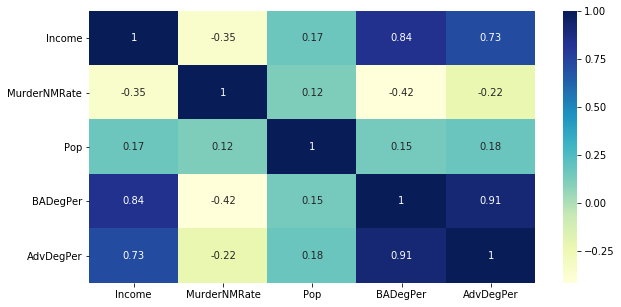

In [30]:
corr_heatmap(df,['Income','MurderNMRate','Pop','BADegPer','AdvDegPer'])

In [31]:
vif5 = compute_vif('LifeExp2018 ~ Income + Region + MurderNMRate + Pop + BADegPer + AdvDegPer',df)
vif5

,VIF Factor,Sqrt,features
0,109.417824,10.460297,Intercept
1,2.362127,1.536921,Region[T.Northeast]
2,2.068202,1.438124,Region[T.South]
3,1.686867,1.298795,Region[T.West]
4,3.873636,1.968155,Income
5,2.064866,1.436964,MurderNMRate
6,1.077051,1.037811,Pop
7,14.521196,3.810669,BADegPer
8,10.230329,3.198488,AdvDegPer


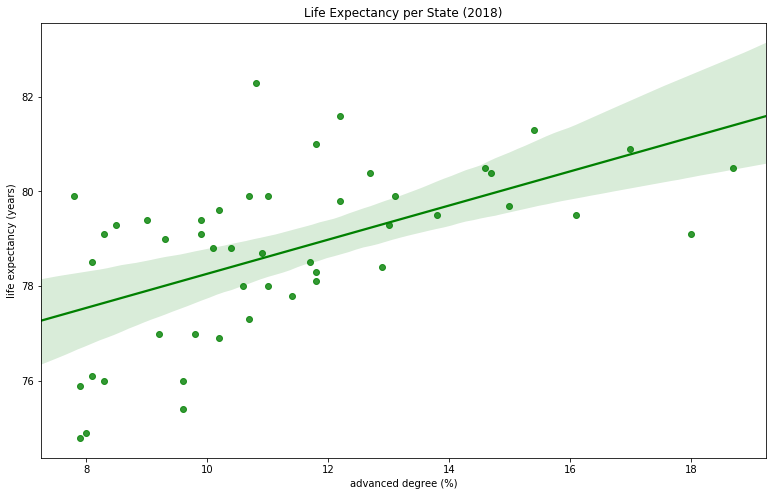

In [32]:
# Regression plot for life expectancy vs. advanced degree
fig, ax0 = plt.subplots(figsize=(13, 8))
sns.regplot(x = "AdvDegPer", y = "LifeExp2018", data=df, color="green", ax=ax0)
ax0.set_title("Life Expectancy per State (2018)")
ax0.set(xlabel="advanced degree (%)", ylabel="life expectancy (years)")
plt.show()

## 5.2 Regression Diagnostics

We'll run a regression of our selected model: 'LifeExp2018 ~ Income + Region + MurderNMRate+ Pop'

In [33]:
y, X4 = dmatrices('LifeExp2018 ~ Income + Region + MurderNMRate+ Pop', data=df, return_type='dataframe')
mod4 = sm.OLS(y, X4)    # Describe model
fit4 = mod4.fit()       # Fit model
print(fit4.summary())   # Summarize model

                            OLS Regression Results                            
Dep. Variable:            LifeExp2018   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     37.31
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           4.32e-15
Time:                        14:55:31   Log-Likelihood:                -50.028
No. Observations:                  48   AIC:                             114.1
Df Residuals:                      41   BIC:                             127.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              73.4473    

In [34]:
fit4.rsquared_adj

0.822541580777441

In [35]:
vif = compute_vif('LifeExp2018 ~ Income + Region + MurderNMRate + Pop ',df)
vif

,VIF Factor,Sqrt,features
0,62.402270,7.899511,Intercept
1,1.712407,1.308590,Region[T.Northeast]
2,1.851830,1.360820,Region[T.South]
3,1.598558,1.264341,Region[T.West]
4,1.382659,1.175865,Income
5,1.671919,1.293027,MurderNMRate
6,1.070487,1.034644,Pop


### 1. Normality
The residuals should be normally distributed with a mean 0.
To check normality we will use a Q-Q-Plot. We have provided you with a fuction. 

In [36]:
def Q_Q_plot(fit):
    """ Prints a Q-Q plot    
    Parameters
    ----------
    fit: fitted model
    
    Returns
    -------
    plot as fig, ax
    
    annotates observations with abs(studentized residual) >= 2
    """
    
    student_resid = pd.Series(fit.get_influence().resid_studentized_internal, index = fit.resid.index, name='StudentResid')
    student_resid.sort_values(ascending = True, inplace= True)
    df = pd.DataFrame(student_resid)
    df['TheorQuant'] = stats.probplot(df['StudentResid'], dist = 'norm', fit = False)[0]
    rankings = abs(df['StudentResid']).sort_values(ascending = False)

    fig, ax0 = plt.subplots(figsize=(15, 9))
    x = df['TheorQuant']
    y = df['StudentResid']
    ax0.scatter(x,y)
    ax0.set(title ='Normal Q-Q', xlabel = 'Theoretical Quantiles', ylabel = 'Studentized Residuals')
    ax0.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
    df['Diff'] = abs(df['TheorQuant'] - df['StudentResid'])
    print(df)
    for idx in df.index:
        if df.loc[idx,'Diff'] > 0.25:
            ax0.annotate(idx,xy=(df['TheorQuant'].loc[idx],df['StudentResid'].loc[idx]))
    return fig, ax0

                StudentResid  TheorQuant      Diff
State                                             
Ohio               -2.419746   -2.187945  0.231801
West_Virginia      -2.102916   -1.814667  0.288249
Kentucky           -1.774936   -1.594039  0.180898
New_Hampshire      -1.733173   -1.431526  0.301647
Indiana            -1.589636   -1.299910  0.289726
Alaska             -1.405085   -1.187618  0.217467
Utah               -1.045058   -1.088587  0.043529
Tennessee          -1.000171   -0.999219  0.000951
Massachusetts      -0.947823   -0.917195  0.030628
New_Jersey         -0.947198   -0.840920  0.106278
Wyoming            -0.768179   -0.769250  0.001071
Pennsylvania       -0.757660   -0.701330  0.056331
Oklahoma           -0.721312   -0.636502  0.084810
Washington         -0.614761   -0.574245  0.040516
Mississippi        -0.445334   -0.514140  0.068807
California         -0.424755   -0.455838  0.031083
Michigan           -0.411445   -0.399047  0.012398
Missouri           -0.216602   

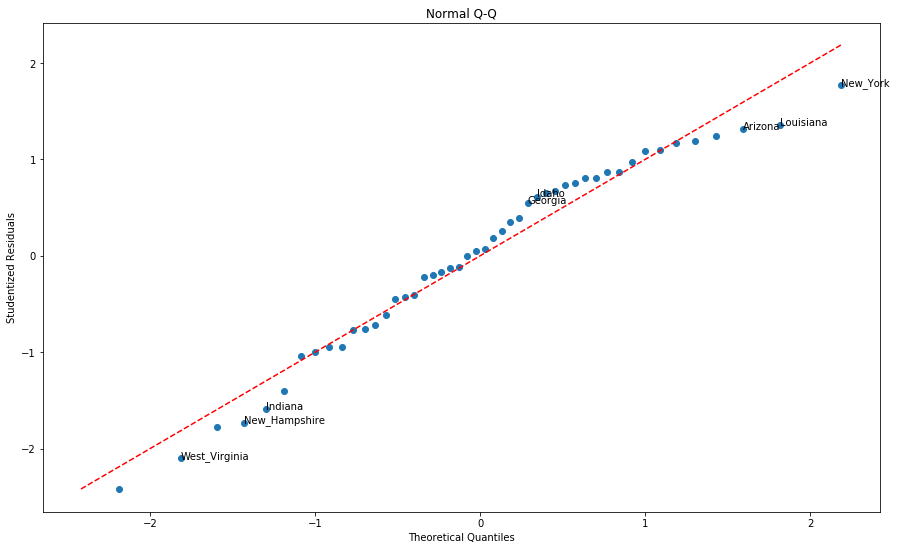

In [37]:
# check if our regression 'LifeExp2018 ~ MurderNMTot' satisfies the normality check.
# check if the points on this graph fall on the straight 45-degree line
Q_Q_plot(fit4)
plt.show()

If the model satisfies the normality assumption, the points on this graph should fall on a staight 45-degree line. Some points fall apart from this line, so the model violates the normality assumption. Deleting outliers and influential observations can often improve a dataset's fit to the normality assumption.   
A transformation of the response variable may also solve this issue.

### 2. Linearity
If the dependent variable is linearly related to the independent variable there should be no systematic relationship between the residuals and the fitted values.   
In the Residuals vs. Fitted plot you should see only noise.

In [38]:
def residuals_vs_fitted(fit, n):
    """ Prints a residuals vs fitted plot    
    Parameters
    ----------
    fit: fitted model
    n: annotate the top n observations (the ones with the largest residuals)
    
    Returns
    -------
    plot as fig, ax
    """

    fig, ax0 = plt.subplots(figsize = (9,8))

    # plot residuals vs. fitted
    residuals = fit.resid
    fitted = fit.fittedvalues
    ax0.scatter(fitted, residuals)

    # plot a lowess red curve
    curve = lowess(residuals,fitted)
    curve_x = curve[:,0]
    curve_y = curve[:,1]
    ax0.plot(curve_x,curve_y,color = 'r')
    
    # plot a dashed horizontal line at zero
    ax0.hlines(0, min(fitted), max(fitted), colors='black',linestyle = '--', alpha = .5 )

    # set title and labels
    ax0.set_title('Residuals vs. Fitted')
    ax0.set(ylabel = 'Residuals', xlabel='Fitted Values')

    # annotate top n observations
    topN = abs(residuals).sort_values(ascending = False)[:n]
    for id in topN.index:
        ax0.annotate(id,xy=(fitted[id],residuals[id]))

    return fig, ax0

[]

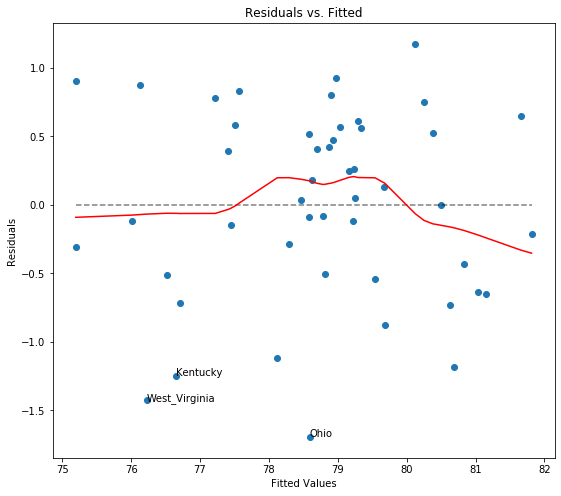

In [39]:
# Check if our regression of 'LifeExp2018 ~ MurderNMTot' satisfies the linearity assumption
fig, ax0 = residuals_vs_fitted(fit4, 3)
plt.savefig("./img/residuals_vs_fitted.png")    
plt.plot()

In the plot "Residuals v. Fitted" we saw a curved pattern in the central of the values. This pattern may require further investigation with other plots like "Regressors vs. Fitted" plots or "Component + Residuals" plots and a lack-of-fit test.

### 3. Constant Variance (Homocedasticity)
If the model meets the constant variance assumption, the points on the Scale-Location graph should be a randomly distributed around an horizontal line. 

In [40]:
def scale_location_plot(fit, n):
    """ Prints a scale-location plot    
    Parameters
    ----------
    fit: fitted model
    n: annotate the top n observations
    
    Returns
    -------
    plot as fig, ax
    """
 
    fig, ax0 = plt.subplots( figsize = (9,8))

    # get the square root of the studentized residuals
    student_resid = fit.get_influence().resid_studentized_internal
    sqrt_student_resid = pd.Series(np.sqrt(np.abs(student_resid)), index = fit.resid.index)

    # get the fitted values
    fitted = fit.fittedvalues

    # plot the square root of the studentized residuals vs. the fitted values
    ax0.scatter(fitted, sqrt_student_resid)

    # plot a lowess red curve
    smoothed = lowess(sqrt_student_resid,fitted)
    ax0.plot(smoothed[:,0],smoothed[:,1],color = 'r')


    ax0.set(xlabel = 'Fitted Values', ylabel = '$\sqrt{|Studentized \ Residuals|}$', title = 'Scale-Location Plot')
    ax0.set_ylim(0,max(sqrt_student_resid)+0.1)

    # compute the top n observations 
    topN = abs(sqrt_student_resid).sort_values(ascending = False)[:n]

    # annotate the top n observations
    for id in topN.index:
        ax0.annotate(id,xy=(fitted[id],sqrt_student_resid[id]))
    return fig, ax0

[]

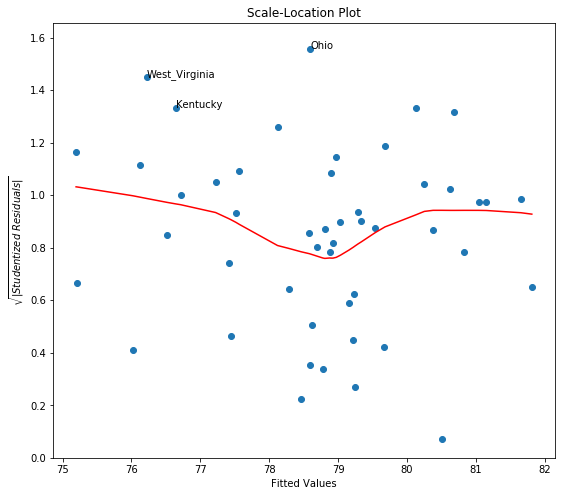

In [41]:
fig, ax0 = scale_location_plot(fit4,3)
plt.savefig("./img/scale_location.png")    
plt.plot()

On the scale-location plot we want to check that  
- the red line is approximately horizontal   
- the spread around the line does not vary with the fitted values   
The red line has a little curvature in the middle. We should run other tests to check for homocedasticity.

## 5.3 Unusual observations
Check outliers, high-leverage points, and influential observations in the selected model

### 1.Outliers

In [42]:
def check_outliers(fit, bound = 2):
    """ Prints studentized redisuals whose absolute value exceed 2
    Parameters
    ----------
    fit: fitted model
    
    Returns
    -------
    nothing
    """
    influence_obj = fit.get_influence()
    student_resid = influence_obj.resid_studentized_internal
    student_resid_series = pd.Series(student_resid, index = fit.resid.index, name = 'StudentResid')
    print("Outliers\nStudentized residuals")
    for id, val in student_resid_series.items():
        if abs(val) >= bound:
            print(id, val)
    return

In [43]:
# outliers test
check_outliers(fit4, 2)

Outliers
Studentized residuals
Ohio -2.4197463233562666
West_Virginia -2.10291592042564


### 2. High-leverage Points

In [44]:
def hat_values_plot(fit):
    """ Prints hat values plot
    Parameters
    ----------
    fit: fitted model
    
    Returns
    -------
    plot as fig, ax

    h_bar = p/n : mean hat value
    Observations whose hat values are >= 2 * h_bar are annotated
    p: number of parameters estimated in the model (including the intercept)
    n: sample size
    """
    # number of regressors + 1
    p = len(fit.params)
    # number of observations
    n = len(fit.fittedvalues)
    # mean hat value
    mean_hat = p/n
    # get OLSInfluence Object
    influence_obj = fit.get_influence()
    # retrieve hat values
    hat_values = influence_obj.hat_matrix_diag # get the hat values from the OLSInfluence object
    hat_values_series = pd.Series(hat_values, index = fit.resid.index, name='HatValues')
    fig, ax0 = plt.subplots(figsize = (15,9))
    ax0.set(title="Index Plot of Hat Values")
    ax0.axhline(y=mean_hat, color='b', linestyle='dotted', linewidth=1, label = "mean hat")
    ax0.axhline(y=2*mean_hat, color='g', linestyle='--', linewidth=1, label = "mean hat * 2")
    ax0.axhline(y=3*mean_hat, color='r', linestyle='--', linewidth=1, label = "mean hat * 3")
    markerline, stemlines, baseline = ax0.stem(hat_values_series.index,hat_values_series, linefmt = 'b-.', basefmt='None', use_line_collection=True)
    plt.xticks(rotation =90)
    # annotate hat values that >= 2 * mean_hat
    bound = 2 * mean_hat
    print("Hat values greater that bound: {:.4f}".format(bound))
    for id, val in hat_values_series.items():
        if val >= bound:
            ax0.annotate(id,xy=(id,val))
            print("{}: {:.2f}".format(id,val))
    ax0.legend()
    return fig, ax0


   

Hat values greater that bound: 0.2917
California: 0.55
Maryland: 0.34


(<Figure size 1080x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c21a51450>)

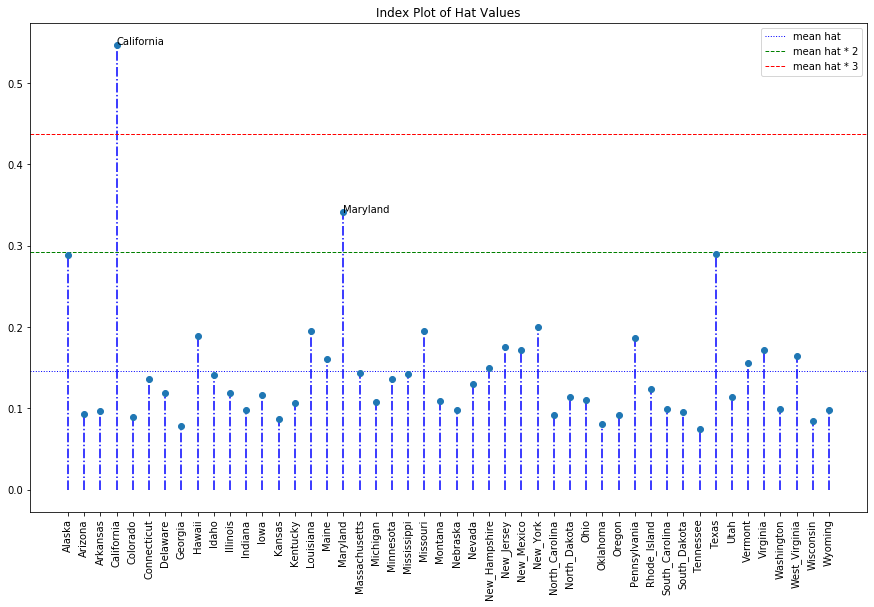

In [45]:
# test high-leverage points
hat_values_plot(fit4)

The states of California and Maryland show unusual hat values. This may need further investigation.

### 3. Influential Observations

In [46]:
def cooks_dist_plot(fit):
    """ Prints a Cook's distance plot
    Parameters
    ----------
    fit: fitted model
    
    Returns
    -------
    plot as fig, ax

    p: number of parameters estimated in the model (including the intercept)
    n: sample size
    observations with a Cook's distance that exceeds 4/(n-p-2) should be annotated

    """

    p = len(fit.params)
    n = len(fit.fittedvalues)
    bound = 4/(n-p-2)

    # get OLSInfluence Object
    influence_obj = fit.get_influence()
    # get Cook's distances
    cooks_dist = influence_obj.cooks_distance[0] # get the cook's distances from the OLSInfluence object
    cooks_dist_series = pd.Series(cooks_dist, index = fit.resid.index, name='CookDist')
    # plot the distances
    fig, ax0 = plt.subplots(figsize = (15,9))
    ax0.set(title="Cook's Distance Plot")
    ax0.axhline(y=bound, color='g', linestyle='--', linewidth=1, label ="4/(n-k-1)")
    ax0.axhline(y=1, color='r', linestyle='--', linewidth=1, label ="1")
 
    markerline, stemlines, baseline = ax0.stem(cooks_dist_series.index,cooks_dist_series, linefmt = 'b-.', basefmt='None', use_line_collection=True)
    plt.xticks(rotation =90)
    # annotate values with Cook's distance >= bound
    print("Observations with Cook's distance greater that bound: {:.4f}".format(bound))
    for id, val in cooks_dist_series.items():
        if val >= bound:
            ax0.annotate(id,xy=(id,val))
            print("{}: {:.2f}".format(id,val))
    ax0.legend()
    return fig, ax0  

Observations with Cook's distance greater that bound: 0.1026
Alaska: 0.11
New_York: 0.11
Ohio: 0.10
West_Virginia: 0.12


[]

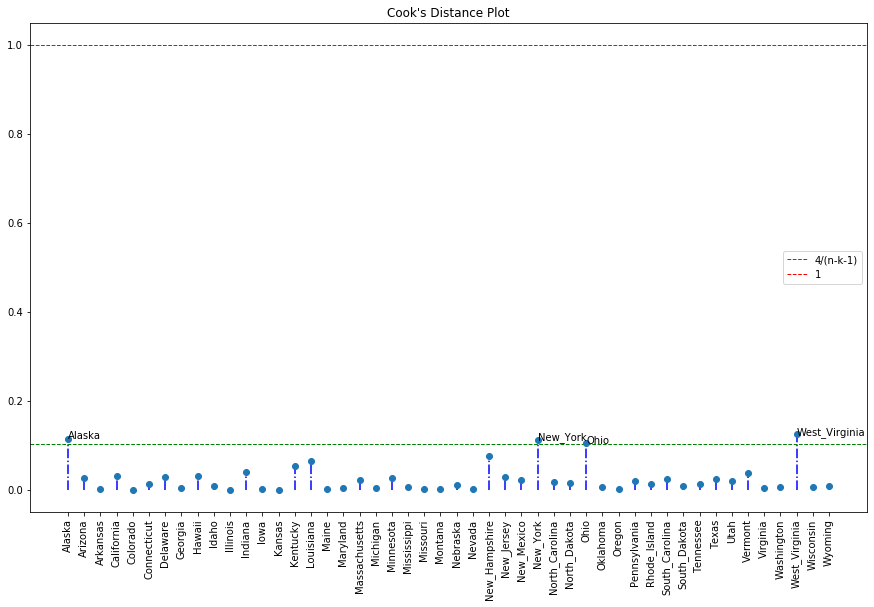

In [47]:
# test influential observations
fig, ax0 = cooks_dist_plot(fit4)
plt.plot()

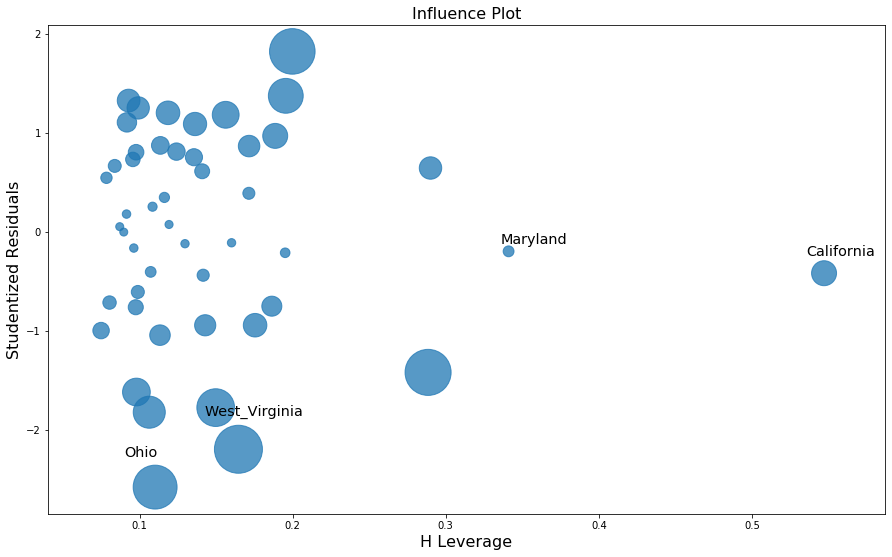

In [48]:
# test influential observations with Influence plot
fig, ax0 = plt.subplots(figsize=(15, 9))
sm.graphics.influence_plot(fit4,  ax = ax0, criterion="cooks")

plt.show()

### 4. Evaluation

####  Evaluate the results

Regarding the primary objective, we have found a model that satisfies the measure of success (R2 >= 0.75). 
The secondary objective of answering the data mining questions has been achieved in milestone 3.

####  Further steps

Due to several issues found in the plots, the model may require further investigation. The Q-Q plot showed a departure from normality. The "Residuals vs. Fitted" plot showed , further investigation is necessary.   

### Data Exploration Report: Unusual Observations

#### Outliers

We considered *outliers* those observations with a studentized residual s such that:
-1.9 <= s <= 1.9

   State       |  Stud. Resid.  
-------------- |----------- 
Ohio           |  -2.4197
West Virginia  |  -2.1029

#### High-leverage observations

We considered *high-leverage* points those observations with a hat value h greater that 2 times the mean hat value:
h >= 0.2917

   State       |  Stud. Resid.  
-------------- |----------- 
California     |   0.55
Maryland       |   0.34

#### Influential Observations

We considered *influential observations* those observations with a Cook's distance d such that:
d >= 0.1026   
We computed the bound using the formula 4/(n-p-2) where:   
p: number of parameters estimated in the model (including the intercept)    
n: sample size   
    
   State      | Cook's distance
------------- |----------- 
Alaska        |  0.11 
New York      |  0.11 
Ohio          |  0.10 
West Virginia |  0.12 

Using the cutoff of 4/(n-p-2) there are 4 observations that are influential, but they lay very near the cutoff. 

